In [6]:
import numpy as np
import pandas as pd
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline

from  sklearn.metrics  import accuracy_score

pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_columns', 500)

In [2]:
#loading data
df_sampled = pd.read_pickle('df_sampled.pkl')

In [7]:
df_sampled.head()

,rating,fullTextHtml
555,1,"<p></p>\n<p><strong>Klappentext (Lovelybooks):</strong></p> \n<p><br></p> \n<p>Ally d’Aplièse steht an einem Wendepunkt: Ihre Karriere als Seglerin strebt einem Höhepunkt entgegen, und sie hat den Mann gefunden, mit dem sich all ihre Wünsche erfüllen. Da erhält sie völlig unerwartet die Nachricht vom Tod ihres geliebten Vaters. Ally kehrt zurück zum Familiensitz am Genfer See, um den Schock gemeinsam mit ihren Schwestern zu bewältigen. Sie alle wurden als kleine Mädchen adoptiert und kennen ..."
729,1,"<p></p>\n<p><strong>Nicht nur der Flop des Jahres, sondern vielleicht sogar des Jahrzehnts!</strong></p>\n<p>Die 1971 in Irland geborene Autorin arbeitete zunächst als Schauspielerin für Theater-, Film- und Fernsehproduktionen bevor sie diese Erfahrungen zum Schreiben inspirierten. Der vorliegende Roman ist nach <a href=""https://www.lovelybooks.de/autor/Lucinda-Riley/Die-Sturmschwester-1187258204-w/rezension/1534933720/"" rel=""nofollow"" target=""_blank""><strong>„Die Sturmschwester“</strong></a..."
1636,1,"<p><br>Nach diesen Seiten, die schon ungefähr ein Drittel des Buches ausmachen, war ich äußerst gernevt. Bedauerlicherweise war es mein erstes Buch von Ursula Poznanski, weshalb ich nun sehr überlege, ob ich es mit ""Die Verratenen"" versuchen sollte, denn war dieses Buch aus meiner Sicht schlecht.<br><br>Es beginnt relativ typisch und verfolgt die allbekannten Schemen vieler Geschichten von heutzutage, so zum Beispiel, dass ausgerechnet die Hauptperson merkt, dass etwas nicht stimmt und alle ..."
1676,1,"<p>Inhalt:<br>In den Tiefen der Familienbibliothek ist Furia auf der Suche nach einem ganz besonderen Buch: ihrem Seelenbuch. Mit ihm will sie die Magie und die Macht der Worte entfesseln. Doch dann wird ihr Bruder entführt, und Furia muss um sein Leben kämpfen. Ihr Weg führt sie nach Libropolis, die Stadt der verschwundenen Buchläden ...<br><br><br>Cover:<br>Das Cover ist ansprechend gestaltet durch das schwarz verspricht es eine düstere Handlung.<br><br>Die geschwungenen Buchstaben gefalle..."
1677,1,"<p>Ich bin ja auch immer auf der Suche nach Raritäten. Neue Bücher, alte Bücher, antikes... Was auch immer. Und hier wird von sowas erzählt. Gefesselt hat mich die Geschichte leider nicht.<br></p>"


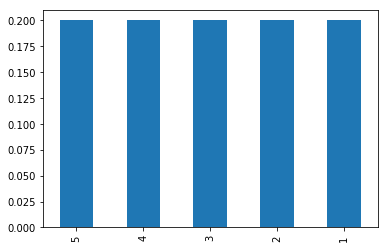

In [4]:
df_sampled['rating'].value_counts(normalize=True).plot(kind='bar');

In [5]:
#changing 'rating' column to integer
df_sampled['rating'] = df_sampled['rating'].astype(int)

In [9]:
X = df_sampled['fullTextHtml'].values
y = df_sampled['rating'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8888)

In [16]:
np.unique(y_train, return_counts=True)

(array([1, 2, 3, 4, 5]), array([2985, 3004, 2969, 2992, 3005], dtype=int64))

In [17]:
np.unique(y_test, return_counts=True)

(array([1, 2, 3, 4, 5]), array([1003,  984, 1019,  996,  983], dtype=int64))

In [18]:
#bag of words
#Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, 
#which builds a dictionary of features and transforms documents to feature vectors

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(14955, 132234)

In [19]:
#checking some typical words if they are in vocabulary
count_vect.vocabulary_.get('wunderbar')

126738

In [20]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(14955, 132234)

NAIVE BAYES

In [21]:
#training a Naive Bayes classifier
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [28]:
#testing on some simple examples
docs_new = ['Film war wunderbar', 'Das Film was schrecklich']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

In [29]:
predicted = clf.predict(X_new_tfidf)
predicted

array([5, 1])

In [30]:
#In order to make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class
#that behaves like a compound classifier

text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
 ])

In [31]:
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [35]:
#evaluation on test set
predicted = text_clf.predict(X_test)
print(accuracy_score(y_test,predicted))

0.4615847542627884


SVM

In [36]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=8888,
                          max_iter=5, tol=None)),
])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
print(accuracy_score(y_test,predicted))

0.5305917753259779


In [37]:
#more detailed metrics
print(metrics.classification_report(y_test, predicted, target_names=['1','2','3','4','5']))

              precision    recall  f1-score   support

           1       0.59      0.80      0.68      1003
           2       0.48      0.33      0.39       984
           3       0.52      0.36      0.43      1019
           4       0.46      0.33      0.38       996
           5       0.54      0.84      0.66       983

    accuracy                           0.53      4985
   macro avg       0.52      0.53      0.51      4985
weighted avg       0.52      0.53      0.51      4985



XGBOOST

In [38]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', xgb.XGBClassifier(random_state=8888, max_depth=5, n_estimators=200, objective='multi:softmax', num_class=5)),
])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
print(accuracy_score(y_test,predicted))

0.524974924774323


In [39]:
#more detailed metrics
print(metrics.classification_report(y_test, predicted, target_names=['1','2','3','4','5']))

              precision    recall  f1-score   support

           1       0.66      0.65      0.65      1003
           2       0.48      0.49      0.48       984
           3       0.47      0.39      0.43      1019
           4       0.44      0.44      0.44       996
           5       0.56      0.66      0.61       983

    accuracy                           0.52      4985
   macro avg       0.52      0.53      0.52      4985
weighted avg       0.52      0.52      0.52      4985

